<a href="https://colab.research.google.com/github/loaychlih/Sentiment-Analysis-of-Customer-Reviews/blob/main/Sentiment_Analysis_of_Customer_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BENCHMARKING (WHICH MODEL IS MORE SUITABLE FOR MY SENTIMENT ANALYSIS TASK ?)**

In [ ]:
from bs4 import BeautifulSoup
import requests
import csv

base_url = 'https://www.trustpilot.com/review/www.zalando.co.uk?page='
reviews = []

for page_number in range(1, 25):
    url = base_url + str(page_number)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find all review elements
    review_elements = soup.find_all(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
    # Find all rating elements
    rating_elements = soup.find_all('div', class_='styles_reviewHeader__iU9Px')  # Adjust class as needed

    # Loop through both reviews and ratings
    for review_element, rating_element in zip(review_elements, rating_elements):
        review_text = review_element.get_text(strip=True)
        rating_value = int(rating_element['data-service-review-rating'])  # Convert rating to an integer

        # Determine sentiment based on the rating
        sentiment = 1 if rating_value >= 3 else 0

        reviews.append((review_text, rating_value, sentiment))  # Store review, rating, and sentiment as a tuple

# Save the reviews, ratings, and sentiments to a CSV file
with open('/content/drive/MyDrive/sentiment_analysis/reviews_with_ratings_and_sentiment.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Review', 'Rating', 'Sentiment'])  # Column headers
    csvwriter.writerows(reviews)  # Write the reviews, ratings, and sentiments

do an analysis on the length of these tokens

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK tokenizer resources if not already available
nltk.download('punkt')

# Load the DataFrame
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_ratings_and_sentiment.csv')

# Tokenize the reviews and find the length of tokens for each review
df['num_tokens'] = df['Review'].apply(lambda x: len(word_tokenize(str(x))))

# Find the maximum number of tokens
max_tokens = df['num_tokens'].max()

print(f"The maximum number of tokens in a review is: {max_tokens}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The maximum number of tokens in a review is: 654


we find ourself needing to truncate some of the tokens to 512 which is the Maximum Tokens of inputs for our benchmarking models ---------------- add les liens dial les models li khdit

In [ ]:
import pandas as pd
from tqdm import tqdm  # For progress tracking
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the CSV file with reviews, ratings, and sentiments
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_ratings_and_sentiment.csv')

# Load tokenizers and models
tokenizer_roberta = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model_roberta = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")
pipeline_roberta = pipeline("sentiment-analysis", model=model_roberta, tokenizer=tokenizer_roberta)

tokenizer_cardiff = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_cardiff = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
pipeline_cardiff = pipeline("sentiment-analysis", model=model_cardiff, tokenizer=tokenizer_cardiff)

pipeline_distilbert = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
pipeline_deberta = pipeline("text-classification", model="yangheng/deberta-v3-large-absa-v1.1")

# Dictionary to store results
res = {}
error_ids = []  # List to store IDs that broke

# Use DataFrame index as ID if 'Id' column is missing
for i, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis Progress"):
    try:
        text = row['Review']
        myid = row.get('Id', i)  # Use row index if 'Id' column doesn't exist

        # RoBERTa sentiment analysis
        roberta_result = pipeline_roberta(text)[0]
        roberta_result = {f"roberta_{key}": value for key, value in roberta_result.items()}

        # Cardiff NLP RoBERTa sentiment analysis
        cardiff_result = pipeline_cardiff(text)[0]
        cardiff_result = {f"cardiff_{key}": value for key, value in cardiff_result.items()}

        # DistilBERT sentiment analysis
        distilbert_result = pipeline_distilbert(text)[0]
        distilbert_result = {f"distilbert_{key}": value for key, value in distilbert_result.items()}

        # DeBERTa sentiment analysis
        deberta_result = pipeline_deberta(text)[0]
        deberta_result = {f"deberta_{key}": value for key, value in deberta_result.items()}

        # Combine all results
        both = {**roberta_result, **cardiff_result, **distilbert_result, **deberta_result}
        res[myid] = both

    except RuntimeError:
        print(f'Broke for ID {myid}')
        error_ids.append(myid)  # Store the broken ID

# Remove rows with the broken IDs from the DataFrame
df = df[~df.index.isin(error_ids)]  # Keep only rows that are not in error_ids

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(res, orient='index')

# Save the results to a new CSV file
results_df.to_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_sentiment_analysis_results.csv', index=True)

# Display final DataFrame
print("Final DataFrame preview:")
print(results_df.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Sentiment Analysis Progress:  39%|███▉      | 186/473 [09:33<14:29,  3.03s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Broke for ID 186


Sentiment Analysis Progress:  53%|█████▎    | 251/473 [12:33<13:37,  3.68s/it]

Broke for ID 251


Sentiment Analysis Progress:  84%|████████▍ | 397/473 [19:34<05:04,  4.00s/it]

Broke for ID 397


Sentiment Analysis Progress:  92%|█████████▏| 437/473 [21:39<02:17,  3.83s/it]

Broke for ID 437


Sentiment Analysis Progress: 100%|██████████| 473/473 [23:22<00:00,  2.97s/it]

Final DataFrame preview:
  roberta_label  roberta_score cardiff_label  cardiff_score distilbert_label  \
0      POSITIVE       0.998935       LABEL_2       0.922490         NEGATIVE   
1      POSITIVE       0.998887       LABEL_2       0.496618         NEGATIVE   
2      POSITIVE       0.998928       LABEL_2       0.966884         POSITIVE   
3      POSITIVE       0.998936       LABEL_2       0.948103         POSITIVE   
4      NEGATIVE       0.999510       LABEL_0       0.950836         NEGATIVE   

   distilbert_score deberta_label  deberta_score  
0          0.796364      Positive       0.988292  
1          0.886253      Positive       0.944446  
2          0.999856      Positive       0.999769  
3          0.999788      Positive       0.999014  
4          0.998964      Negative       0.975465  


In [ ]:
import pandas as pd
results_df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_sentiment_analysis_results.csv')
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_ratings_and_sentiment.csv')

In [ ]:
print(results_df.head())

  roberta_label  roberta_score cardiff_label  cardiff_score distilbert_label  \
0      POSITIVE       0.998935       LABEL_2       0.922490         NEGATIVE   
1      POSITIVE       0.998887       LABEL_2       0.496618         NEGATIVE   
2      POSITIVE       0.998928       LABEL_2       0.966884         POSITIVE   
3      POSITIVE       0.998936       LABEL_2       0.948103         POSITIVE   
4      NEGATIVE       0.999510       LABEL_0       0.950836         NEGATIVE   

   distilbert_score deberta_label  deberta_score  
0          0.796364      Positive       0.988292  
1          0.886253      Positive       0.944446  
2          0.999856      Positive       0.999769  
3          0.999788      Positive       0.999014  
4          0.998964      Negative       0.975465  


In [ ]:
print(df.head())

                                              Review  Rating  Sentiment
0  Absolutely perfect service. Ordered trainers o...       5          1
1  I have placed 3 different orders this year wit...       5          1
2  Everything as expected! Thankfully I took the ...       5          1
3  I was concerned after reading the reviews but ...       5          1
4  Shocking service. Parcel has been delayed, nob...       1          0


In [ ]:
# Merge DataFrames based on their row index
merged_df = pd.concat([df, results_df], axis=1)
print(merged_df.head())
# Save the merged DataFrame to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/sentiment_analysis/reviews_with_sentiment_analysis_comparisons.csv', index=False)

                                              Review  Rating  Sentiment  \
0  Absolutely perfect service. Ordered trainers o...       5          1   
1  I have placed 3 different orders this year wit...       5          1   
2  Everything as expected! Thankfully I took the ...       5          1   
3  I was concerned after reading the reviews but ...       5          1   
4  Shocking service. Parcel has been delayed, nob...       1          0   

  roberta_label  roberta_score cardiff_label  cardiff_score distilbert_label  \
0      POSITIVE       0.998935       LABEL_2       0.922490         NEGATIVE   
1      POSITIVE       0.998887       LABEL_2       0.496618         NEGATIVE   
2      POSITIVE       0.998928       LABEL_2       0.966884         POSITIVE   
3      POSITIVE       0.998936       LABEL_2       0.948103         POSITIVE   
4      NEGATIVE       0.999510       LABEL_0       0.950836         NEGATIVE   

   distilbert_score deberta_label  deberta_score  
0          0.7963

In [ ]:
import pandas as pd
from tqdm import tqdm  # For progress tracking
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a mapping for standard sentiment labels to binary (1 for POSITIVE, 0 for NEGATIVE, 2 for NEUTRAL)
def map_labels(pred):
    if pred.upper() == "POSITIVE":  # Use upper() to handle case sensitivity
        return 1
    elif pred.upper() == "NEGATIVE":
        return 0
    elif pred.upper() == "NEUTRAL":
        return 0  # Optional handling for NEUTRAL
    else:
        return 2  # Fallback for unknown labels

# Define a mapping for Cardiff NLP labels (0 -> Negative, 1 -> Neutral, 2 -> Positive)
def map_cardiff_labels(pred):
    if pred == "LABEL_2":  # Positive
        return 1
    elif pred == "LABEL_0":  # Negative
        return 0
    elif pred == "LABEL_1":  # Neutral
        return 0  # Treat Neutral as Negative
    else:
        return 2  # Fallback for unexpected labels

# Evaluate each model
for model_name in ['roberta', 'distilbert', 'deberta', 'cardiff']:
    if model_name == 'cardiff':
        # For Cardiff NLP, map the labels using the specific mapping
        pred_binary = [map_cardiff_labels(p) for p in results_df[f'{model_name}_label']]
    else:
        # For other models, map using the standard labels
        pred_binary = [map_labels(p) for p in results_df[f'{model_name}_label']]

    # Calculate performance metrics
    accuracy = accuracy_score(df['Sentiment'], pred_binary)
    precision = precision_score(df['Sentiment'], pred_binary, average='weighted', zero_division=0)
    recall = recall_score(df['Sentiment'], pred_binary, average='weighted', zero_division=0)
    f1 = f1_score(df['Sentiment'], pred_binary, average='weighted', zero_division=0)

    # Print the results
    print(f"Results for {model_name.capitalize()}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}\n")

Results for Roberta:
  Accuracy: 0.9339
  Precision: 0.9341
  Recall: 0.9339
  F1-score: 0.9328

Results for Distilbert:
  Accuracy: 0.8785
  Precision: 0.8823
  Recall: 0.8785
  F1-score: 0.8724

Results for Deberta:
  Accuracy: 0.9168
  Precision: 0.9193
  Recall: 0.9168
  F1-score: 0.9142

Results for Cardiff:
  Accuracy: 0.9083
  Precision: 0.9101
  Recall: 0.9083
  F1-score: 0.9054



In [ ]:
merged_df.columns

Index(['Review', 'Rating', 'Sentiment', 'roberta_label', 'roberta_score',
       'cardiff_label', 'cardiff_score', 'distilbert_label',
       'distilbert_score', 'deberta_label', 'deberta_score'],
      dtype='object')

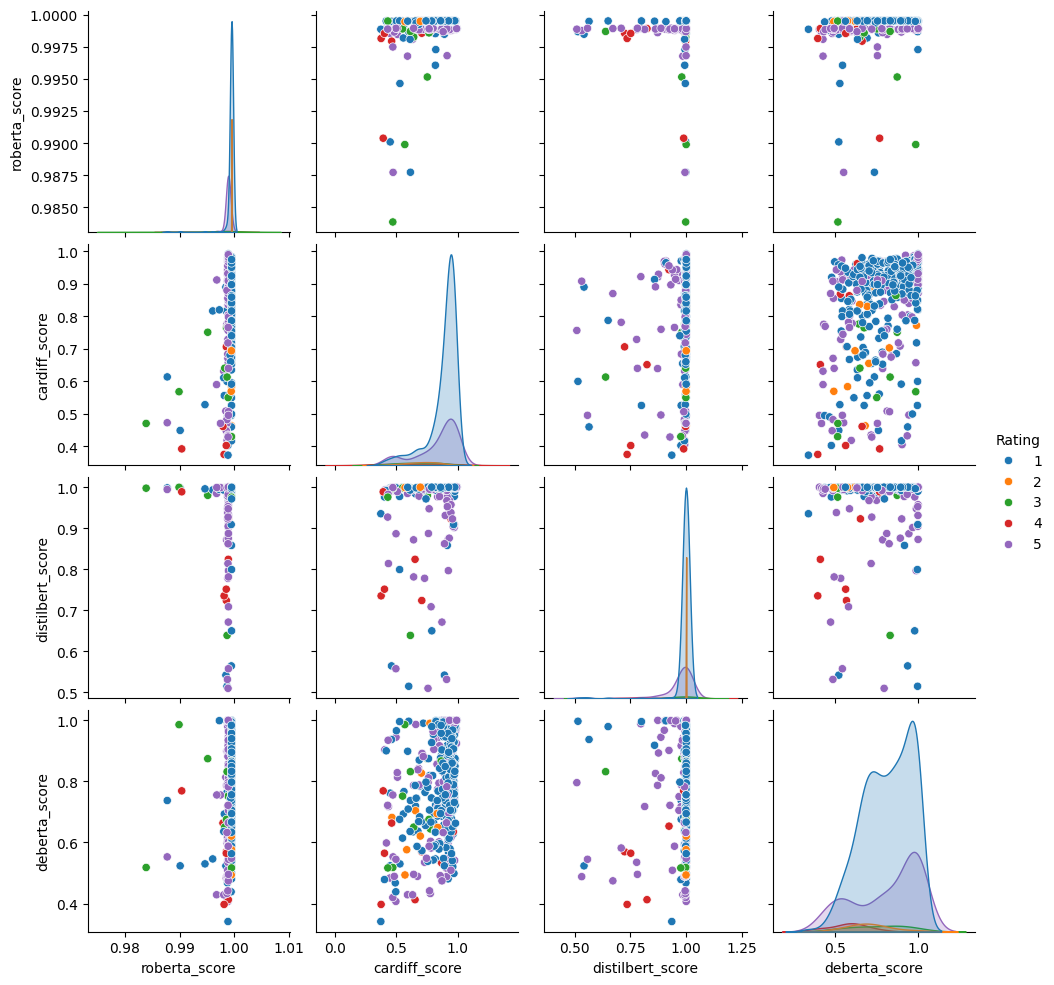

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Pairplot with the correct syntax
sns.pairplot(
    data=merged_df,
    vars=['roberta_score', 'cardiff_score', 'distilbert_score', 'deberta_score'],
    hue='Rating',
    palette='tab10'
)

# Show the plot
plt.show()

TODO : Add reviews and download the csv file to your machine so you can make an analysis / ask gpt for further analysis suggestions/ put it in github (And see how people put their collab projects) ; ADD COMMENTS


# **SENTIMENT ANALYSIS OF ZOLANDO REVIEWS**

import reviews + analysis of labels(positive/negatives)/ most words used in the reviews for negative ones and positive ones (main topics)

In [ ]:
base_url = 'https://www.trustpilot.com/review/www.zalando.co.uk?page='
reviews = []

for page_number in range(1, 100):
    url = base_url + str(page_number)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find all review elements
    review_elements = soup.find_all(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
    # Find all rating elements
    rating_elements = soup.find_all('div', class_='styles_reviewHeader__iU9Px')  # Adjust class as needed

    # Loop through both reviews and ratings
    for review_element, rating_element in zip(review_elements, rating_elements):
        review_text = review_element.get_text(strip=True)
        rating_value = int(rating_element['data-service-review-rating'])  # Convert rating to an integer

        # Determine sentiment based on the rating
        sentiment = 1 if rating_value >= 3 else 0

        reviews.append((review_text, rating_value, sentiment))  # Store review, rating, and sentiment as a tuple

# Save the reviews, ratings, and sentiments to a CSV file
with open('/content/drive/MyDrive/sentiment_analysis/reviews_analysis.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Review', 'Rating', 'Sentiment'])  # Column headers
    csvwriter.writerows(reviews)  # Write the reviews, ratings, and sentiments

In [ ]:
import pandas as pd
from tqdm import tqdm  # For progress tracking
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Check if GPU is available and use it
device = 0 if torch.cuda.is_available() else -1  # -1 for CPU, 0 for GPU

# Load the CSV file with reviews, ratings, and sentiments
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/reviews_analysis.csv')

# Load the RoBERTa tokenizer and model
tokenizer_roberta = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model_roberta = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")
pipeline_roberta = pipeline("sentiment-analysis", model=model_roberta, tokenizer=tokenizer_roberta, device=device)

# Dictionary to store results
res = {}
error_ids = []  # List to store IDs that broke

# Use DataFrame index as ID if 'Id' column is missing
for i, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis Progress"):
    try:
        text = row['Review']
        myid = row.get('Id', i)  # Use row index if 'Id' column doesn't exist

        # RoBERTa sentiment analysis
        roberta_result = pipeline_roberta(text)[0]
        roberta_result = {f"roberta_{key}": value for key, value in roberta_result.items()}

        # Store results
        res[myid] = roberta_result

    except RuntimeError:
        print(f'Broke for ID {myid}')
        error_ids.append(myid)  # Store the broken ID

# Remove rows with the broken IDs from the DataFrame
df = df[~df.index.isin(error_ids)]  # Keep only rows that are not in error_ids

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(res, orient='index')

# Merge the original DataFrame with the results DataFrame
reviews_roberta_results_df = pd.merge(df, results_df, left_index=True, right_index=True, how='inner')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Sentiment Analysis Progress:  10%|▉         | 189/1958 [00:06<01:00, 29.30it/s]

Broke for ID 186


Sentiment Analysis Progress:  13%|█▎        | 255/1958 [00:08<00:43, 39.58it/s]

Broke for ID 251


Sentiment Analysis Progress:  20%|██        | 401/1958 [00:12<00:51, 30.43it/s]

Broke for ID 397


Sentiment Analysis Progress:  23%|██▎       | 441/1958 [00:14<00:46, 32.41it/s]

Broke for ID 437


Sentiment Analysis Progress:  30%|███       | 591/1958 [00:18<00:34, 39.24it/s]

Broke for ID 586


Sentiment Analysis Progress:  35%|███▍      | 676/1958 [00:20<00:28, 44.63it/s]

Broke for ID 668


Sentiment Analysis Progress:  40%|███▉      | 779/1958 [00:22<00:35, 33.21it/s]

Broke for ID 774


Sentiment Analysis Progress:  57%|█████▋    | 1116/1958 [00:32<00:22, 37.60it/s]

Broke for ID 1108


Sentiment Analysis Progress:  82%|████████▏ | 1608/1958 [00:53<00:14, 24.05it/s]

Broke for ID 1604
Broke for ID 1606


Sentiment Analysis Progress:  88%|████████▊ | 1726/1958 [00:57<00:05, 39.14it/s]

Broke for ID 1719


Sentiment Analysis Progress: 100%|██████████| 1958/1958 [01:04<00:00, 30.46it/s]


NameError: name 'reviews_roberta_results' is not defined

In [ ]:
# Save the merged results to a new CSV file
reviews_roberta_results_df.to_csv('/content/drive/MyDrive/sentiment_analysis/reviews_roberta_results.csv', index=True)

# Display final DataFrame
print("Final DataFrame preview:")
print(reviews_roberta_results_df.head())

Final DataFrame preview:
                                              Review  Rating  Sentiment  \
0  Absolutely perfect service. Ordered trainers o...       5          1   
1  I have placed 3 different orders this year wit...       5          1   
2  Everything as expected! Thankfully I took the ...       5          1   
3  I was concerned after reading the reviews but ...       5          1   
4  Shocking service. Parcel has been delayed, nob...       1          0   

  roberta_label  roberta_score  
0      POSITIVE       0.998935  
1      POSITIVE       0.998887  
2      POSITIVE       0.998928  
3      POSITIVE       0.998936  
4      NEGATIVE       0.999510  


<ipython-input-36-b31873f1a4f8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=labels_count, x='Label', y='Count', palette='tab10')


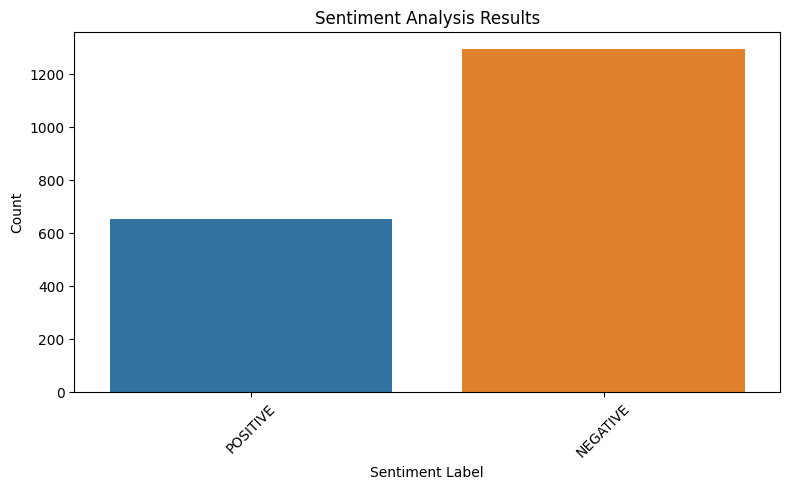

In [ ]:
from nltk import FreqDist

labels = reviews_roberta_results_df['roberta_label']
# Count occurrences using NLTK's FreqDist
label_freq = FreqDist(labels)

# Prepare data for plotting
labels_count = pd.DataFrame(label_freq.items(), columns=['Label', 'Count'])

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=labels_count, x='Label', y='Count', palette='tab10')
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit titles and labels
plt.show()

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Ensure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Filter for positive reviews
positive_reviews = reviews_roberta_results_df[reviews_roberta_results_df['roberta_label'] == 'POSITIVE']['Review']

# Tokenize and clean the words
stop_words = set(stopwords.words('english'))
all_words = []

for review in positive_reviews:
    words = word_tokenize(review.lower())  # Convert to lowercase
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    all_words.extend(words)

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the most common words
most_common_words = word_freq.most_common(20)  # Get top 20 most common words

# Display the results
print("Most Common Words in Positive Reviews:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Words in Positive Reviews:
zalando: 380
service: 280
reviews: 271
delivery: 257
order: 253
ordered: 221
great: 185
arrived: 173
customer: 170
good: 170
days: 157
time: 155
item: 148
would: 128
company: 114
experience: 112
within: 105
items: 102
refund: 101
received: 99


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Ensure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Filter for positive reviews
negative_reviews = reviews_roberta_results_df[reviews_roberta_results_df['roberta_label'] == 'NEGATIVE']['Review']

# Tokenize and clean the words
stop_words = set(stopwords.words('english'))
all_words = []

for review in negative_reviews:
    words = word_tokenize(review.lower())  # Convert to lowercase
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    all_words.extend(words)

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the most common words
most_common_words = word_freq.most_common(20)  # Get top 20 most common words

# Display the results
print("Most Common Words in Positive Reviews:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Words in Positive Reviews:
zalando: 1044
order: 854
refund: 832
customer: 660
service: 639
company: 506
back: 504
item: 472
received: 442
ordered: 428
items: 427
never: 417
money: 413
parcel: 396
would: 391
days: 390
still: 388
get: 386
time: 372
return: 359


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from collections import Counter

# Ensure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Filter for positive reviews
positive_reviews = reviews_roberta_results_df[reviews_roberta_results_df['roberta_label'] == 'POSITIVE']['Review']

# Tokenize and clean the words
stop_words = set(stopwords.words('english'))
bigram_count = Counter()

for review in positive_reviews:
    words = word_tokenize(review.lower())  # Convert to lowercase
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords

    # Count bigrams
    bigram_count.update(bigrams(words))

# Get the most common bigrams
most_common_bigrams = bigram_count.most_common(10)  # Change the number to get more bigrams

# Display the results
print("Most Common Bigrams in Positive Reviews:")
for bigram, freq in most_common_bigrams:
    print(f"{bigram}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Bigrams in Positive Reviews:
('customer', 'service'): 116
('bad', 'reviews'): 63
('negative', 'reviews'): 56
('within', 'days'): 32
('reading', 'reviews'): 29
('first', 'time'): 26
('days', 'later'): 25
('would', 'definitely'): 24
('quick', 'delivery'): 23
('arrived', 'within'): 23


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from collections import Counter

# Ensure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Filter for positive reviews
negative_reviews = reviews_roberta_results_df[reviews_roberta_results_df['roberta_label'] == 'NEGATIVE']['Review']

# Tokenize and clean the words
stop_words = set(stopwords.words('english'))
bigram_count = Counter()

for review in negative_reviews:
    words = word_tokenize(review.lower())  # Convert to lowercase
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords

    # Count bigrams
    bigram_count.update(bigrams(words))

# Get the most common bigrams
most_common_bigrams = bigram_count.most_common(10)  # Change the number to get more bigrams

# Display the results
print("Most Common Bigrams in Positive Reviews:")
for bigram, freq in most_common_bigrams:
    print(f"{bigram}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Bigrams in Positive Reviews:
('customer', 'service'): 442
('money', 'back'): 103
('customer', 'services'): 64
('get', 'refund'): 61
('still', 'waiting'): 60
('sent', 'back'): 59
('placed', 'order'): 55
('even', 'though'): 54
('received', 'refund'): 54
('received', 'email'): 51


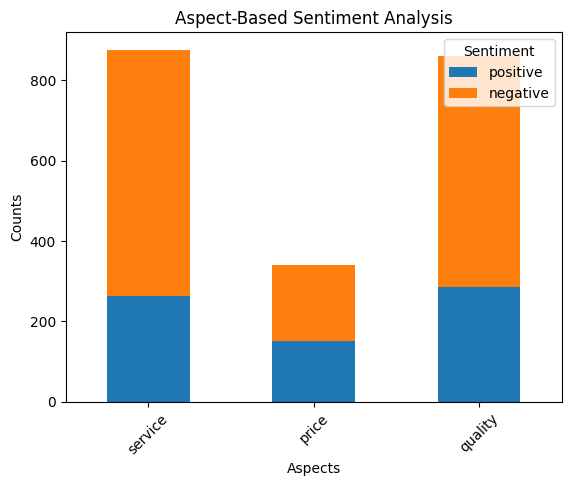

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define keywords for each aspect
aspects = {
    'service': ['service', 'staff', 'customer support', 'help'],
    'price': ['price', 'cost', 'value'],
    'quality': ['quality', 'product', 'item', 'material']
}

# Initialize a dictionary to store counts
aspect_sentiments = {aspect: {'positive': 0, 'negative': 0} for aspect in aspects.keys()}

# Analyze sentiment for each aspect
for aspect, keywords in aspects.items():
    for _, row in reviews_roberta_results_df.iterrows():
        review = row['Review'].lower()
        sentiment = row['roberta_label']
        if any(keyword in review for keyword in keywords):
            aspect_sentiments[aspect][sentiment.lower()] += 1

# Convert results to DataFrame for visualization
aspect_df = pd.DataFrame(aspect_sentiments).T

# Plotting
aspect_df.plot(kind='bar', stacked=True)
plt.title('Aspect-Based Sentiment Analysis')
plt.xlabel('Aspects')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper right')
plt.show()
